## Chapter 9
# Virtual Musical Instruments
## Clarinet

In [1]:
import numpy as np

import sys
sys.path.append('../')

from Filters import OneZeroFilter
from Generators import NoiseGenerator, SineGenerator
sys.path.append('../musimathics')
from pitches import frequency_for_note_label
note2freq = frequency_for_note_label

import matplotlib.pyplot as plt
%matplotlib inline

from DelayLine import DelayLine
from SamplePlayer import SamplePlayer, WavPlayer
from AllpassDelay import AllpassDelay

sample_rate = fs = 44100
lowest_frequency = note2freq('A0')
highest_frequency = note2freq('C8')

In [2]:
# This class implements a simple one breakpoint,
# non-linear reed function, as described by
# Smith (1986).  This function is based on a
# memoryless non-linear spring model of the reed
# (the reed mass is ignored) which saturates when
# the reed collides with the mouthpiece facing.

# See McIntyre, Schumacher, & Woodhouse (1983),
# Smith (1986), Hirschman, Cook, Scavone, and
# others for more information.
class ReedTable:
    def __init__(self):
        self.offset = 0.6
        self.slope = -0.8

    def tick(self, in_sample):
        # The input is differential pressure across the reed.
        out_sample = self.offset + (self.slope * in_sample)

        # If output is > 1, the reed has slammed shut and the
        # reflection function value saturates at 1.0.
        out_sample = min(out_sample, 1.0)

        # This is nearly impossible in a physical system, but
        # a reflection function value of -1.0 corresponds to
        # an open end (and no discontinuity in bore profile).
        out_sample = max(-1.0, out_sample)

        return out_sample

    def key_on(self):
        self.set_target(1.0)

    def key_off(self):
        self.set_target(0.0)

    def set_offset(self, offset):
        self.offset = offset
        
    def set_slope(self, slope):
        self.slope = slope

class EnvelopeGenerator:
    def __init__(self):
        self.target = 0.0
        self.value = 0.0
        self.rate = 0.001
        self.state = False

    def tick(self):
        if self.state:
            if self.target > self.value:
                self.value += self.rate
                if self.value >= self.target:
                    self.value = self.target
                    self.state = 0
            else:
                self.value -= self.rate
                if self.value <= self.target:
                    self.value = self.target
                    self.state = False
        return self.value

    def set_rate(self, rate):
        self.rate = rate
    
    def set_target(self, target):
        self.target = target
        if self.value != self.target:
            self.state = True

# envelope + noise + vibrato
class BreathPressureGenerator:
    def __init__(self):
        self.envelope = EnvelopeGenerator()
        self.noise = NoiseGenerator(gain=0.2)
        self.vibrato = SineGenerator()
        self.vibrato.set_frequency(5.735)
        self.vibrato.amplitude = 0.1
        
        self.last_envelope_out = 0.0
        self.last_noise_out = 0.0
        self.last_vibrato_out = 0.0

    def tick(self):
        self.last_noise_out = self.noise.tick()
        self.last_vibrato_out = self.vibrato.tick()

        self.last_envelope_out = self.envelope.tick()
        breath_pressure = self.last_envelope_out
        breath_pressure += breath_pressure * self.last_noise_out
        breath_pressure += breath_pressure * self.last_vibrato_out

        return breath_pressure

    # Apply breath pressure to instrument with given amplitude and rate of increase.
    def start_blowing(self, amplitude, rate):
        assert(amplitude > 0 and rate > 0)

        self.envelope.set_rate(rate)
        self.envelope.set_target(amplitude)

    # Decrease breath pressure with given rate of decrease.
    def stop_blowing(self, rate):
        self.envelope.set_rate(rate)
        self.envelope.set_target(0.0)

    def set_vibrato_frequency(self, vibrato_frequency):
        self.vibrato.set_frequency(vibrato_frequency)

    def set_vibrato_gain(self, vibrato_gain):
        self.vibrato.amplitude = vibrato_gain
    
    def set_noise_gain(self, noise_gain):
        self.noise.gain = noise_gain

    
class Clarinet:
    def __init__(self):
        self.filter = OneZeroFilter()
        self.breath_pressure_gen = BreathPressureGenerator()
        self.output_gain = 1.0

        max_delay_samples = 0.5 * fs / lowest_frequency
        self.delay_line = AllpassDelay(max_delay_samples, int(max_delay_samples) + 1)

        self.reed_table = ReedTable()
        self.set_reed_stiffness(0.5)

        self.set_frequency(note2freq('A3'))
        self.clear()
        
        self.last_breath_pressure_out = 0.0

    def tick(self):
        self.last_breath_pressure_out = self.breath_pressure_gen.tick()
        # Perform commuted loss filtering.
        self.last_pressure_diff = -0.95 * self.filter.tick(self.delay_line.last_out)
        # Calculate pressure difference of reflected and mouthpiece pressures.
        self.last_pressure_diff -= self.last_breath_pressure_out
        self.last_reed_table_out = self.reed_table.tick(self.last_pressure_diff)
        # Perform non-linear scattering using pressure difference in reed function.
        return self.output_gain * self.delay_line.tick(self.last_breath_pressure_out +
                                                       self.last_pressure_diff*self.last_reed_table_out)

    def note_on(self, frequency, amplitude):
        self.set_frequency(frequency)
        self.breath_pressure_gen.start_blowing(0.55 + (amplitude * 0.3), amplitude * 0.001)
        self.output_gain = amplitude + 0.001

    def note_off(self, amplitude):
        self.breath_pressure_gen.stop_blowing(amplitude * 0.01)

    def set_frequency(self, frequency):
        # Account for filter delay and one sample "last out" delay.
        delay = 0.5 * (fs / frequency) - 1.0#self.filter.phase_delay(frequency) - 1.0
        self.delay_line.set_delay_samples(delay)

    # Realtime controls
    def set_reed_stiffness(self, reed_stiffness):
        self.reed_table.set_slope(-0.44 + (0.26 * reed_stiffness))
    def set_noise_gain(self, noise_gain):
        self.breath_pressure_gen.set_noise_gain(noise_gain)
    def set_vibrato_frequency(self, vibrato_frequency):
        self.breath_pressure_gen.set_vibrato_frequency(vibrato_frequency)
    def set_vibrato_gain(self, vibrato_gain):
        self.breath_pressure_gen.set_vibrato_gain(vibrato_gain)

    def clear(self):
        self.delay_line.clear()
        self.filter.clear()

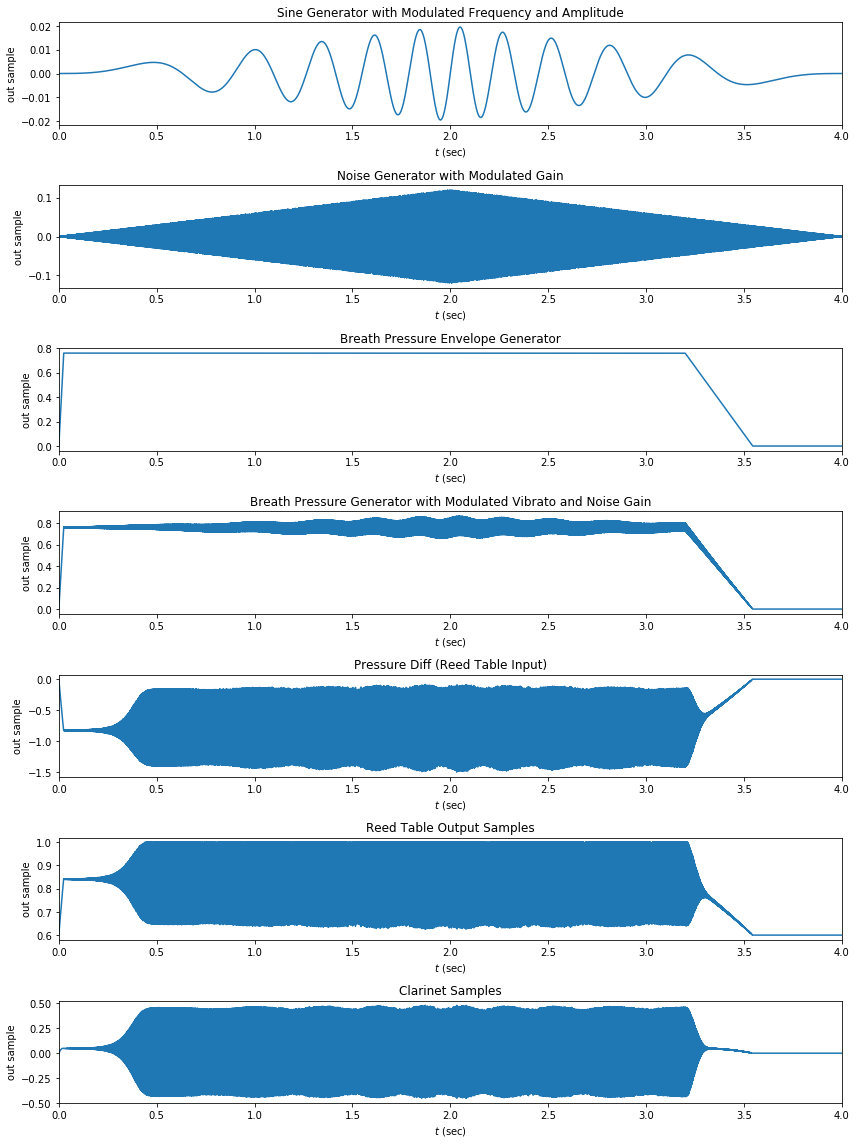

In [10]:
fig, plots = plt.subplots(7, 1, figsize=(12, 16))
[sine_plot, noise_plot, envelope_plot, breath_plot, pressure_diff_plot, reed_table_plot, clarinet_plot] = plots

clarinet = Clarinet()
clarinet.set_reed_stiffness(0.57)

t = np.arange(4 * fs) / fs
triangle = np.concatenate([np.linspace(0, 1, t.size // 2),
                           np.linspace(1, 0, t.size // 2)])
noise_gain_ramp = triangle * 0.12
vibrato_frequency_ramp = triangle * 5
vibrato_gain_ramp = triangle * 0.02

sine_y = np.zeros(t.size)
noise_y = np.zeros(t.size)
envelope_y = np.zeros(t.size)
breath_y = np.zeros(t.size)
pressure_diff_y = np.zeros(t.size)
reed_table_out_samples = np.zeros(t.size)
clarinet_out_samples = np.zeros(t.size)

breath_duration_samples = int(4*t.size//5) # hold for 4/5 of the duration
clarinet.note_on(note2freq('F4'), 0.7)

for i in range(t.size):
    if i == breath_duration_samples:
        clarinet.note_off(0.005)

    clarinet.set_vibrato_frequency(vibrato_frequency_ramp[i])
    clarinet.set_vibrato_gain(vibrato_gain_ramp[i])
    clarinet.set_noise_gain(noise_gain_ramp[i])

    clarinet_out_samples[i] = clarinet.tick()

    sine_y[i] = clarinet.breath_pressure_gen.last_vibrato_out
    noise_y[i] = clarinet.breath_pressure_gen.last_noise_out
    envelope_y[i] = clarinet.breath_pressure_gen.last_envelope_out
    breath_y[i] = clarinet.last_breath_pressure_out
    pressure_diff_y[i] = clarinet.last_pressure_diff
    reed_table_out_samples[i] = clarinet.last_reed_table_out

sine_plot.plot(t, sine_y)
sine_plot.set_title('Sine Generator with Modulated Frequency and Amplitude')

noise_plot.plot(t, noise_y)
noise_plot.set_title('Noise Generator with Modulated Gain')

envelope_plot.plot(t, envelope_y)
envelope_plot.set_title('Breath Pressure Envelope Generator')

breath_plot.plot(t, breath_y)
breath_plot.set_title('Breath Pressure Generator with Modulated Vibrato and Noise Gain')

pressure_diff_plot.plot(t, pressure_diff_y)
pressure_diff_plot.set_title('Pressure Diff (Reed Table Input)')

reed_table_plot.plot(t, reed_table_out_samples)
reed_table_plot.set_title('Reed Table Output Samples')

clarinet_plot.plot(t, clarinet_out_samples)
clarinet_plot.set_title('Clarinet Samples')

for plot in plots:
    plot.set_xlim(0, t.size / fs)
    plot.set_xlabel('$t$ (sec)')
    plot.set_ylabel('out sample')

plt.tight_layout()

In [11]:
from IPython.display import Audio

Audio(clarinet_out_samples, rate=fs)

In [12]:
from scipy.io.wavfile import write as write_wav
write_wav('clarinet_mod_vibrato_and_noise.wav', rate=fs, data=clarinet_out_samples)

In [6]:
# TODO plot reed table

Here is an example of a much more elaborate and realistic clarinet model: [github link](https://github.com/Eigenlabs/EigenD/blob/f5614c98d12c85c4db5f0026797b881eb94b220e/plg_stk/src/Clarinet2.cpp)

It's based [this Csound Clarinet implementation](http://www.csounds.com/jmc/Articles/Woodwinds/Csound%20Woodwinds.htm) by Josep M Comajuncosas.
